In [1]:
import altair as alt
# We are using default data transformer for html chart to work offline 
# alt.data_transformers.enable('default')
alt.data_transformers.enable('json')
# alt.data_transformers.enable('csv')
# alt.data_transformers.enable('default', max_rows=1000000)
# alt.renderers.enable('notebook')
# alt.data_transformers.enable('data_server')
alt.renderers.enable('notebook', embed_options={'renderer': 'svg'})
from vega_datasets import data
import pandas as pd
from altair import Scale,Color

In [2]:
file = 'annual_county_level.csv'

In [3]:
# Reading the original dataframe
dforg = pd.read_csv(file,header=0)

In [4]:
# Looking at the data in the dataframe
dforg.head()

,Unnamed: 0,state,fips,year,BUYER_COUNTY,pills,population,Pill_per_pop
0,1,AK,2013,2006,ALEUTIANS EAST,300.0,2794,0.107373
1,2,AK,2013,2007,ALEUTIANS EAST,100.0,3012,0.033201
2,3,AK,2016,2006,ALEUTIANS WEST,26700.0,5658,4.718982
3,4,AK,2016,2007,ALEUTIANS WEST,33500.0,5466,6.128796
4,5,AK,2016,2008,ALEUTIANS WEST,30000.0,5393,5.562767


In [5]:
# Looking at the statistics of the data
dforg.describe()

,Unnamed: 0,fips,year,pills,population,Pill_per_pop
count,20988.000000,20988.000000,20988.000000,2.098800e+04,2.098800e+04,20988.000000
mean,10494.500000,30287.508529,2009.000000,3.646579e+06,1.010772e+05,38.562225
std,6058.858061,15118.266208,2.001572,9.739507e+06,3.153288e+05,24.920452
min,1.000000,1001.000000,2006.000000,2.000000e+01,4.890000e+02,0.005968
25%,5247.750000,18173.000000,2007.000000,3.506825e+05,1.285575e+04,22.587628
50%,10494.500000,29118.000000,2009.000000,1.080840e+06,2.769200e+04,34.015286
75%,15741.250000,45041.500000,2011.000000,3.076068e+06,7.005025e+04,48.676498
max,20988.000000,56045.000000,2012.000000,2.326166e+08,9.840024e+06,501.605074


In [6]:
# Looking at the data-types of the columns
dforg.dtypes

Unnamed: 0        int64
state            object
fips              int64
year              int64
BUYER_COUNTY     object
pills           float64
population        int64
Pill_per_pop    float64
dtype: object

In [7]:
# Changing the data-types of non-numeric to str
dforg['Pill_per_pop'] = dforg["Pill_per_pop"].astype(int)
dforg['BUYER_COUNTY'] = dforg["BUYER_COUNTY"].astype(str)
dforg['state'] = dforg["state"].astype(str)
# Year will be used as column names, hence, we have to convert to str
dforg['year'] = dforg["year"].astype(str)

In [8]:
# Subset the data selecting the required columns
fdf = dforg[['fips','year','Pill_per_pop','BUYER_COUNTY','state']]

In [9]:
# Rows having pills per person >150 are =150 to cap off.
fdf.loc[fdf['Pill_per_pop']>150,['Pill_per_pop']] = 150

C:\Users\Satya\Anaconda3\envs\dviz\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# We now take another subset from the above subsetted data
fdfn = fdf[['fips','year','Pill_per_pop']]

fdfn = fdfn.pivot(index='fips',columns='year',values='Pill_per_pop').reset_index('fips')


In [11]:
# Storing a list of column names for plotting
columns = [str(i) for i in range(2006,2013)]+['BUYER_COUNTY','state']

In [12]:
# Joining dataframes to add BUYER_COUNTY and state columns
fdfn = fdfn.set_index('fips').join(fdf[['fips','BUYER_COUNTY','state']].set_index('fips'))

In [13]:
# Resetting index to index(fips) column 
fdfn = fdfn.reset_index()

In [14]:
# Setting plotting properties
dummy = 'nothing' #This holds the default fill-in color
scheme = 'yellowgreenblue'
scale_type = 'linear'

In [15]:
# Using based on the color scheme chosen, we check the values in 
# MatplotLib cmaps and take the appropriate hex-code value for dummy
# Since yellowgreenblue is not present in matplotlib, we go to:
# https://htmlcolorcodes.com/color-picker/
# and select the dummy fill-in color of choice.
# Otherwise, if color-scheme is in matplotlib, we use the following code:
# cmap = cm.get_cmap('viridis_r', 15)
# cutoff = 0
# for i in range(cmap.N):
#     rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
#     print(matplotlib.colors.rgb2hex(rgb))
#     if i == cutoff:
#         dummy = matplotlib.colors.rgb2hex(rgb)


In [16]:
dummy = '#EEFBB3'

In [17]:
# Getting the json to plot states and counties
# Make sure there is a defference in the urls
states = alt.topo_feature(data.us_10m.url, 'states')
counties = alt.topo_feature(data.us_10m.url+'#', 'counties')

In [18]:
cols = [str(i) for i in range(2006,2013)]
cols

['2006', '2007', '2008', '2009', '2010', '2011', '2012']

In [19]:
columns

['2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 'BUYER_COUNTY',
 'state']

In [20]:
us_counties = alt.topo_feature(data.us_10m.url, 'counties')

slider = alt.binding_range(min=2006, max=2012, step=1)
select_year = alt.selection_single(name="year", fields=['year'],
                                   bind=slider, init={'year': 2006})

a = alt.Chart(counties).mark_geoshape(
    stroke='black',
    strokeWidth=0.05
).project(
    type='albersUsa'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(fdfn, 'fips', columns)
).transform_fold(
    cols, as_=['year', 'Pill_per_pop']
).transform_calculate(
    year='parseInt(datum.year)',
    Pill_per_pop='isValid(datum.Pill_per_pop) ? datum.Pill_per_pop : -1'  
).encode(
    color = alt.condition(
        'datum.Pill_per_pop > 0',
        alt.Color('Pill_per_pop:Q', scale=alt.Scale(type='linear',scheme='yellowgreenblue')),
        alt.value(dummy),
    tooltip=['BUYER_COUNTY:N', 'state:N','Pill_per_pop:Q','year:Q']
    )).add_selection(
    select_year
).properties(
    width=700,
    height=400
).transform_filter(
    select_year
)

b = alt.Chart(states).mark_geoshape(stroke='black',strokeWidth=0.15).project(
    type='albersUsa'
    )

c = alt.Chart(counties).mark_geoshape(fillOpacity=0
).project(
    type='albersUsa'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(fdfn, 'fips', columns)
).transform_fold(
    cols, as_=['year', 'Pill_per_pop']
).transform_calculate(
    year='parseInt(datum.year)',
    Pill_per_pop='isValid(datum.Pill_per_pop) ? datum.Pill_per_pop : -1'  
).encode(
    tooltip=['BUYER_COUNTY:N', 'state:N','Pill_per_pop:Q','year:Q']
    ).properties(
    title='Pills per person',
    width=700,
    height=400
)

chart = a+b+c

In [21]:
chart.save('chart.html', embed_options={'renderer':'svg'})

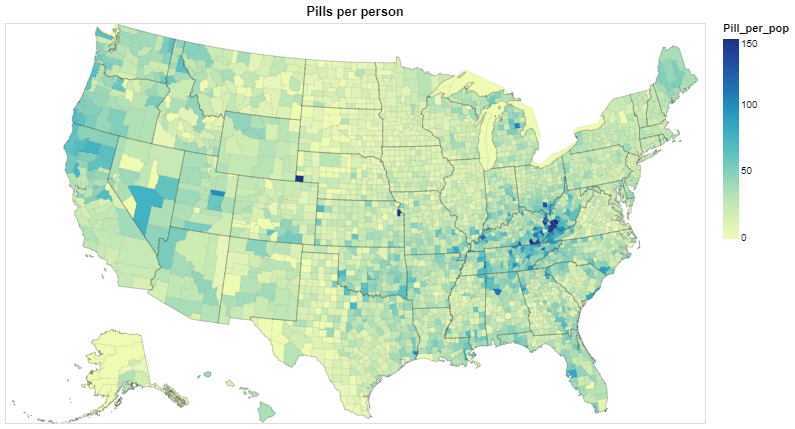

In [22]:
chart.display(renderer='svg')

In [ ]:
# # Plotting function
# def choropleth(data,level,color=True,scheme='yellowgreenblue',dummy=dummy,stroke='black',strokeWidth=0.05,type='linear',fips='fips',columns=columns):
#     foldcols = columns.copy()
#     foldcols.remove('BUYER_COUNTY')
#     foldcols.remove('state')
    
#     slider = alt.binding_range(min=2006, max=2012, step=1)
#     select_year = alt.selection_single(name="key", fields=['key'],
#                                    bind=slider, init={'key': 2006})
    
    
#     if color:
#         chart = alt.Chart(level).mark_geoshape(
#             stroke=stroke,
#             strokeWidth=strokeWidth
#         ).project(
#             type='albersUsa'
#         ).transform_lookup(
#             lookup='id',
#             from_=alt.LookupData(data, fips, columns)
#         ).transform_fold(
#             foldcols,as_=['year','Pill_per_pop']
#         ).transform_calculate(
#             year='parseInt(datum.year)',
#             Pill_per_pop='isValid(datum.Pill_per_pop) ? datum.Pill_per_pop : -1'  
#         ).encode(
#             color = alt.condition(
#                 'datum.Pill_per_pop > 0',
#                 alt.Color('Pill_per_pop:Q', scale=Scale(scheme=scheme,type=type)),
#                 alt.value(dummy)
#                 ),
#             tooltip=['BUYER_COUNTY:N', 'state:N','Pill_per_pop:Q','year:Q']
#         ).add_selection(
#             select_year
#         ).properties(
#             width=700,
#             height=400,
#             title='Pills per person'
#         ).transform_filter(
#             select_year
#         )
#     else:
#         chart = alt.Chart(level).mark_geoshape(
#             stroke=stroke,
#             strokeWidth=strokeWidth
#         ).project(
#             type='albersUsa'
#         ).transform_lookup(
#             lookup='id',
#             from_=alt.LookupData(data, fips, columns)
#         ).transform_fold(
#             foldcols,as_=['year','Pill_per_pop']
#         ).transform_calculate(
#             year='parseInt(datum.year)',
#             Pill_per_pop='isValid(datum.Pill_per_pop) ? datum.Pill_per_pop : -1'  
#         ).encode(
#             tooltip=['BUYER_COUNTY:N', 'state:N','Pill_per_pop:Q','year:Q']
#         ).add_selection(
#             select_year
#         ).properties(
#             width=700,
#             height=400,
#             title='Pills per person'
#         ).transform_filter(
#             select_year
#         )
        
#     return chart

In [ ]:
# def plot_year(year,fdf=fdf,counties=counties,states=states,state_stroke='black',state_strokew=0.15):
    
#     chart = choropleth(fdf1,counties)
    
#     outline = alt.Chart(states).mark_geoshape(stroke=state_stroke,strokeWidth=state_strokew).project(
#     type='albersUsa'
#     )
    
#     chart1 = choropleth(fdf1,counties,color=False,year=year)
    
#     return chart+outline+chart1

In [ ]:
# chart = choropleth(fdfn,counties)